In [1]:
## Library Import

# Basic
import re
import warnings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

# Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# for VIF
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# data load
df = pd.read_csv('original_full_data_20200325.csv', index_col = 0)
mmdf = pd.read_csv('bloomberg_map_index_20200324.csv', index_col = 0)



TARGET_DAY = 5

In [3]:
target = df[['date', 'SKhynix_close']]

In [4]:
df.drop('SKhynix_close', axis = 1, inplace = True)

In [5]:
len(target)

5051

In [6]:
# target preprocessing

target['date'] = pd.to_datetime(target['date'])
target.set_index('date', inplace = True)

In [7]:
target.isna().sum()

SKhynix_close    1632
dtype: int64

In [8]:
target = target.dropna()

In [9]:
len(target)

3419

In [10]:
target = (np.log1p(target) - np.log1p(target).shift(periods = TARGET_DAY, axis = 0))

In [11]:
target = target.shift(-1 * TARGET_DAY)

In [12]:
target = target[:-1 * TARGET_DAY]

In [13]:
target

,SKhynix_close
date,
2006-01-02,-0.022865
2006-01-03,-0.002628
2006-01-04,0.056448
2006-01-05,0.085804
2006-01-06,0.083436
...,...
2019-10-18,0.068647
2019-10-21,0.067356
2019-10-22,0.048127


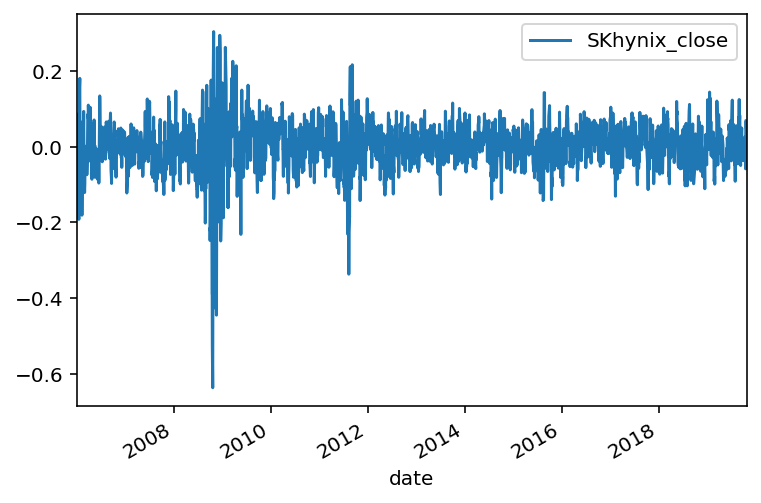

In [14]:
target.plot()

In [15]:
len(target)

3414

In [16]:
# Class generates derived variables & shifting target variable

class Builder:

    def __init__(self, input_df, map_df, target_day):
        self.df = input_df
        self.mdf = map_df
        self.target_day = target_day # just target
        self.lag_days = [5, 20] # lagging for prediction

    # not Bloomberg Economic
    
    def noteco(self, target_column):      

        col_name =  []
        # creating new column name
        for i in self.lag_days:
            col_name.append(target_column + str(i))
            
        # appending lagged columns
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = np.log1p(self.df[target_column]) - np.log1p(self.df[target_column]).shift(periods = j, axis = 0) # 여기에 1을 뺀걸 추가하면 되는거아닌가? 1.얼만에서 1이 빠진거니까

        return self.df 

    # for Bloomberg Economic
    
    def eco(self, target_column):

        col_name = []
        for i in self.lag_days:
            col_name.append(target_column + str(i))
            
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = np.log1p(self.df[target_column]) - np.log1p(self.df[target_column].shift(periods = self.target_day, axis = 0))
        return self.df

    # executing functions
    
    def execution(self):
        for i, j in enumerate(self.mdf['ticker']): # mdf에서 ticker 확인
            if j in self.df.columns:
                    
                if self.mdf.loc[i, :][1] == 'eco':
                    self.eco(j)

                elif self.mdf.loc[i, :][1] == 'noteco':
                    self.noteco(j)
                    self.df.drop(j, axis = 1, inplace = True)

                else:
                    pass
            else:
                pass
                            
        return self.df

In [17]:
len(df.columns)

345

In [18]:
# date preprocessing

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)

In [19]:
# fillna cubic -> ffill -> bfill

#df = df.interpolate(method = 'cubic', limit_area = 'inside')
df = df.fillna(method = 'ffill')
df = df.fillna(method = 'bfill')

In [20]:
# check na value

df.isna().sum().sum()

0

In [21]:
# class load

cla = Builder(df, mmdf, TARGET_DAY)

In [22]:
# execution function
# 새로운 데이터프레임 생성 
cla.execution()

,GDPCQOQIndex,GDPCYOYIndex,GDPCTOT%Index,GPDITOC%Index,GPGSTOC%Index,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,GDPCPCECIndex,CPIYOYIndex,CPIXYOYIndex,PCEDEFYIndex,PCECYOYIndex,CPICHNGIndex,CPUPXCHGIndex,FDIDFDMOIndex,FDIDSGMOIndex,FDIUFDYOIndex,FDIUSGYOIndex,USURTOTIndex,USUDMAERIndex,INJCJCIndex,INJCSPIndex,NFPTCHIndex,...,Microsoft_close20,Nuvoton_close5,Nuvoton_close20,Nvidia_close5,Nvidia_close20,Philadelphia_close5,Philadelphia_close20,QCOM_close5,QCOM_close20,SamsungElectronics_close5,SamsungElectronics_close20,ShinEtsuChemical_close5,ShinEtsuChemical_close20,Siltronic_close5,Siltronic_close20,Sumco_close5,Sumco_close20,TokyoElectron_close5,TokyoElectron_close20,TSMC_close5,TSMC_close20,UMC_close5,UMC_close20,KRXsemiconductor_close5,KRXsemiconductor_close20
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-02,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.7,8.4,326.0,2561.0,278.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.7,8.4,326.0,2561.0,278.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.7,8.4,326.0,2561.0,278.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.7,8.4,326.0,2561.0,278.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.7,8.4,326.0,2561.0,278.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,2.0,2.3,4.6,-6.3,4.8,69.4,21340.27,4.0,2.4,1.9,1.7,2.4,1.4,1.77407,0.1,0.3,0.1,0.3,1.8,2.3,3.7,7.2,210.0,1656.0,219.0,...,0.015671,0.003976,-0.011834,0.044419,0.103503,0.025215,0.053224,0.021166,0.048334,-0.005876,0.063883,0.001387,0.066249,0.042560,0.184395,0.024898,0.150061,0.000482,0.041847,-0.001339,0.058440,0.021440,0.064135,0.017113,0.072362
2019-10-28,2.0,2.3,4.6,-6.3,4.8,69.4,21340.27,4.0,2.4,1.9,1.7,2.4,1.4,1.77407,0.1,0.3,0.1,0.3,1.8,2.3,3.7,7.2,210.0,1656.0,219.0,...,0.056145,-0.023339,-0.030336,0.057954,0.153453,0.062052,0.102230,0.071631,0.129376,0.001951,0.047912,-0.010192,0.075930,0.116544,0.268355,0.033476,0.141203,0.001448,0.032854,0.005299,0.032243,0.015267,0.068993,0.026855,0.059319
2019-10-29,2.0,2.3,4.6,-6.3,4.8,69.4,21340.27,4.0,2.4,1.9,1.7,2.4,1.4,1.77407,0.1,0.3,0.1,0.3,1.8,2.3,3.7,7.2,210.0,1656.0,219.0,...,0.040344,-0.035663,-0.046614,0.030168,0.115316,0.028631,0.075915,0.032834,0.092592,0.007858,0.044006,-0.001742,0.073813,0.100662,0.301446,0.029108,0.145310,0.012990,0.041978,0.019198,0.059338,0.006042,0.073413,0.016271,0.058049


In [23]:
len(df.columns)

970

In [24]:
df.columns

Index(['GDPCQOQIndex', 'GDPCYOYIndex', 'GDPCTOT%Index', 'GPDITOC%Index', 'GPGSTOC%Index',
       'RGCDCIPIIndex', 'GDPCUR$Index', 'GDPCURYIndex', 'GDPPIQQIndex', 'GDPCPCECIndex',
       ...
       'Sumco_close5', 'Sumco_close20', 'TokyoElectron_close5', 'TokyoElectron_close20',
       'TSMC_close5', 'TSMC_close20', 'UMC_close5', 'UMC_close20', 'KRXsemiconductor_close5',
       'KRXsemiconductor_close20'],
      dtype='object', length=970)

In [25]:
df.isna().sum().sum()

274356

In [26]:
# shifting 한 값 날리기

df = df[TARGET_DAY:]

In [27]:
len(df)

5046

In [28]:
len(df)

5046

In [29]:
# nan값이 500을 넘으면 제거 
drop_columns = df.isna().sum().sort_values(ascending = False)[df.isna().sum().sort_values(ascending = False).values>500].index

In [30]:
df.drop(drop_columns, axis = 1, inplace = True)

In [31]:
len(df.columns)

816

In [32]:
# fill na for shifted data

#df = df.interpolate(method = 'cubic', limit_area = 'inside')
df = df.fillna(method = 'ffill')
df = df.fillna(method = 'bfill')

In [33]:
# check na

df.isna().sum().sum()

0

In [34]:
len(df)

5046

In [35]:
# features

len(df.columns)

816

### 이 시점에서 target과 merge

In [36]:
target

,SKhynix_close
date,
2006-01-02,-0.022865
2006-01-03,-0.002628
2006-01-04,0.056448
2006-01-05,0.085804
2006-01-06,0.083436
...,...
2019-10-18,0.068647
2019-10-21,0.067356
2019-10-22,0.048127


In [37]:
merged_df = pd.merge(target, df, how = 'left', on = 'date')

In [38]:
len(merged_df)

3414

In [39]:
df = merged_df.dropna()

In [40]:
df.isna().sum().sum()

0

In [41]:
print('{:.0f}'.format(len(df)/5051*100), '% 만큼 데이터 살았다')

67 % 만큼 데이터 살았다


In [42]:
df

,SKhynix_close,GDPCQOQIndex,GDPCYOYIndex,GDPCTOT%Index,GPDITOC%Index,GPGSTOC%Index,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,GDPCPCECIndex,CPIYOYIndex,CPIXYOYIndex,PCEDEFYIndex,PCECYOYIndex,CPICHNGIndex,CPUPXCHGIndex,FDIDFDMOIndex,FDIDSGMOIndex,FDIUFDYOIndex,FDIUSGYOIndex,USURTOTIndex,USUDMAERIndex,INJCJCIndex,INJCSPIndex,...,Microsoft_close20,Nuvoton_close5,Nuvoton_close20,Nvidia_close5,Nvidia_close20,Philadelphia_close5,Philadelphia_close20,QCOM_close5,QCOM_close20,SamsungElectronics_close5,SamsungElectronics_close20,ShinEtsuChemical_close5,ShinEtsuChemical_close20,Siltronic_close5,Siltronic_close20,Sumco_close5,Sumco_close20,TokyoElectron_close5,TokyoElectron_close20,TSMC_close5,TSMC_close20,UMC_close5,UMC_close20,KRXsemiconductor_close5,KRXsemiconductor_close20
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-09,0.026847,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.7,8.4,326.0,2561.0,...,0.005887,0.000000,0.000000,0.061209,0.126960,0.054049,0.038588,0.045060,0.063705,-0.015862,0.041611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050245,0.037091,0.055271,0.006416,0.040791,-0.015501,0.023197,-0.041353
2006-01-10,-0.048526,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.7,8.4,326.0,2561.0,...,0.005887,0.000000,0.000000,0.041517,0.126960,0.037007,0.038588,0.045890,0.063705,0.027598,0.041611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062810,0.037091,0.027097,0.006416,0.030795,-0.015501,0.045375,-0.041353
2006-01-11,-0.123822,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.7,8.4,326.0,2561.0,...,0.005887,0.000000,0.000000,0.059134,0.126960,0.031893,0.038588,0.029342,0.063705,-0.005839,0.041611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012983,0.037091,0.005585,0.006416,0.010443,-0.015501,0.023446,-0.041353
2006-01-12,-0.091601,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.7,8.4,326.0,2561.0,...,0.005887,0.000000,0.000000,0.046147,0.126960,0.018481,0.038588,0.033350,0.063705,-0.004376,0.041611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022611,0.037091,0.006530,0.006416,0.007795,-0.015501,0.029910,-0.041353
2006-01-13,-0.165142,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.7,8.4,326.0,2561.0,...,0.005887,0.000000,0.000000,0.037614,0.126960,0.013490,0.038588,0.026124,0.063705,0.010138,0.041611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025800,0.037091,-0.005958,0.006416,0.002669,-0.015501,0.046374,-0.041353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-18,0.068647,2.0,2.3,4.6,-6.3,4.8,69.4,21340.27,4.0,2.4,1.9,1.7,2.4,1.4,1.77407,0.1,0.3,0.1,0.3,1.8,2.3,3.7,7.2,206.0,1665.0,...,-0.000654,-0.018991,0.015252,0.023780,0.102932,-0.000650,0.030130,0.012534,0.013435,0.015144,0.030521,0.016169,0.024710,0.072784,0.125428,0.103463,0.142115,0.033852,0.003382,0.041764,0.081891,0.019803,0.039034,0.025926,0.025812
2019-10-21,0.067356,2.0,2.3,4.6,-6.3,4.8,69.4,21340.27,4.0,2.4,1.9,1.7,2.4,1.4,1.77407,0.1,0.3,0.1,0.3,1.8,2.3,3.7,7.2,206.0,1665.0,...,0.000072,-0.040781,-0.013112,0.009179,0.118469,0.011323,0.047918,0.009422,0.044878,-0.007921,0.029250,-0.001751,0.027000,0.046606,0.081920,0.051514,0.158344,0.005806,0.012133,-0.015783,0.047810,0.018692,0.040951,-0.018118,0.028444
2019-10-22,0.048127,2.0,2.3,4.6,-6.3,4.8,69.4,21340.27,4.0,2.4,1.9,1.7,2.4,1.4,1.77407,0.1,0.3,0.1,0.3,1.8,2.3,3.7,7.2,206.0,1665.0,...,0.019718,-0.019725,-0.003976,0.006736,0.121937,0.000269,0.056141,-0.006272,0.058025,0.013766,0.072905,0.004172,0.057118,0.033485,0.141835,0.042925,0.139552,0.008234,0.010669,0.002435,0.059090,0.012461,0.047553,-0.005738,0.054241


In [44]:
df.describe().T.sort_values(by = 'min')[0:24]

,count,mean,std,min,25%,50%,75%,max
RSTAXMOMIndex20,3409.0,NaN,NaN,-inf,0.0,0.0,0.0,inf
KOECEXPYIndex5,3409.0,NaN,NaN,-inf,0.0,0.0,0.0,inf
KOECSGVQIndex20,3409.0,NaN,NaN,-inf,0.0,0.0,0.0,inf
KOMSM1FYIndex20,3409.0,-inf,NaN,-inf,0.0,0.0,0.0,0.532805
KOMSM1FYIndex5,3409.0,-inf,NaN,-inf,0.0,0.0,0.0,0.532805
KOHPTYOYIndex5,3409.0,NaN,NaN,-inf,0.0,0.0,0.0,inf
KOHPTYOYIndex20,3409.0,NaN,NaN,-inf,0.0,0.0,0.0,inf
FDIUFDYOIndex5,3409.0,-inf,NaN,-inf,0.0,0.0,0.0,0.916291
PITLCHNGIndex20,3409.0,NaN,NaN,-inf,0.0,0.0,0.0,inf
PITLCHNGIndex5,3409.0,NaN,NaN,-inf,0.0,0.0,0.0,inf


In [45]:
nan_columns = df.describe().T.sort_values(by = 'min')[0:24].index

In [46]:
df.drop(nan_columns, axis = 1, inplace = True)

In [48]:
df.describe().T.sort_values(by = 'max', ascending = False)

,count,mean,std,min,25%,50%,75%,max
KOHOINCIndex,3409.0,3.945540e+06,567780.560371,2.965551e+06,3449739.000,4092551.000,4403278.000,4.917719e+06
KOHHDIndex,3409.0,9.817710e+05,299861.664252,5.503308e+05,723521.500,940745.600,1203099.200,1.556092e+06
MTSLRL$Index,3409.0,1.325318e+06,102457.818542,1.126129e+06,1261003.000,1311962.000,1402910.000,1.525005e+06
KOHHLIndex,3409.0,9.279530e+05,282429.011865,5.224090e+05,684411.600,885697.300,1137953.100,1.467111e+06
KOVMTOTSIndex,3409.0,3.482465e+05,51759.457428,1.968200e+05,305814.000,358864.000,386621.000,4.644220e+05
...,...,...,...,...,...,...,...,...
NFPTIndex20,3409.0,1.112254e-04,0.000753,-6.040724e-03,0.000,0.000,0.000,4.095098e-03
NFPTIndex5,3409.0,1.112254e-04,0.000753,-6.040724e-03,0.000,0.000,0.000,4.095098e-03
EHCAUSIndex,3409.0,-3.166395e+00,1.291298,-5.940000e+00,-4.210,-2.610,-2.220,-1.910000e+00
USTBTOTIndex,3409.0,-4.715282e+01,9.604433,-6.782300e+01,-54.896,-44.358,-40.752,-2.537200e+01


In [49]:
print('데이터 추출 전 최종 확인', 'shape: ', df.shape, 'nan값 수 :', df.isna().sum().sum())

데이터 추출 전 최종 확인 shape:  (3409, 793) nan값 수 : 0


In [50]:
df.to_csv('hynix_data_5_by_ffill_ver1.csv')